In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# import sys
# sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
# from utils import 

with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)


df_eddies = pd.read_pickle(f'/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/df_eddies_processed_1462_10650.pkl')
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,Q11,Q12,Q22,Rc,psi0,Age,Date,fname
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,-0.008769,0.001546,-0.007521,69.500036,70.832145,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,-0.007934,0.000890,-0.007072,52.250752,156.388574,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,-0.006920,0.001050,-0.006852,67.000485,56.418837,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,-0.006959,0.002144,-0.009312,52.001786,31.355771,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,-0.005883,0.001179,-0.008429,56.251116,29.524244,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115993,2927,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,0.002921,0.000642,0.003759,72.751791,-76.302293,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115994,2927,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,0.002819,0.000983,0.003948,74.250924,-47.064730,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115995,2927,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,0.002968,0.000566,0.003910,75.750780,-79.414689,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115996,2927,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,0.002804,0.000722,0.003863,76.000006,-92.084211,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [4]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


Text(0, 0.5, 'Latitude °N')

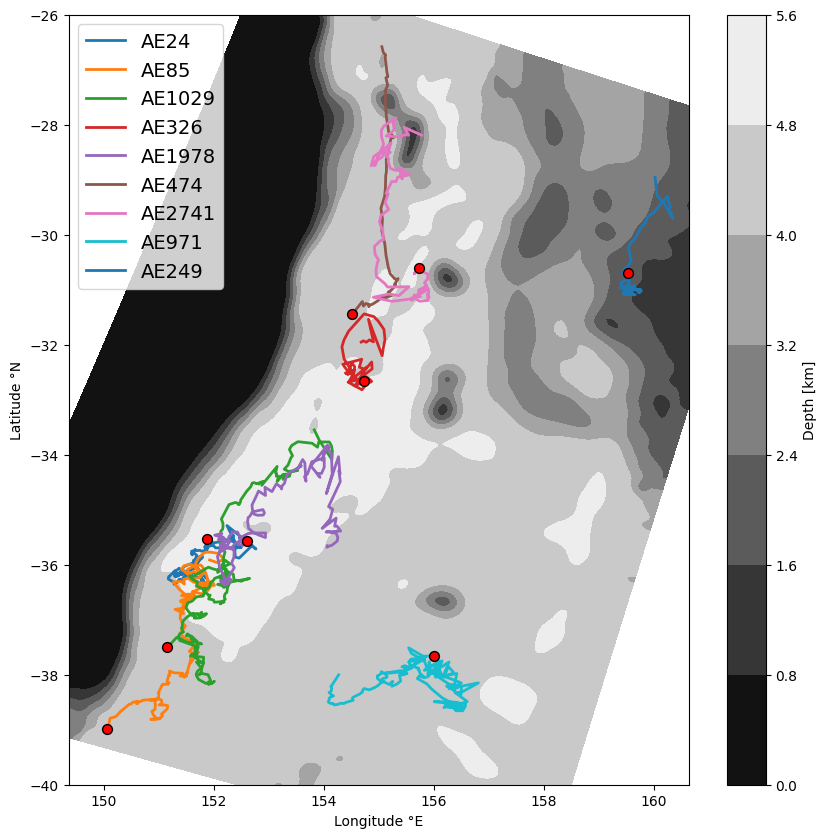

In [24]:
sample_eddies = [24, 85, 1029, 326, 1978, 474, 2741, 971, 249]

plt.figure(figsize=(10,10))
plt.contourf(lon_rho, lat_rho, h/1000, cmap='gray')
plt.colorbar(label='Depth [km]')

colors = plt.get_cmap('tab10').colors * 2

for e, eddy in enumerate(sample_eddies):
    if e >= 7:
        e += 2
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    cyc = df.iloc[0].Cyc
    plt.plot(df['Lon'], df['Lat'], label=f'{cyc}{eddy}',
            linewidth=2, color=colors[e%len(colors)])
    plt.scatter(df.iloc[-1]['Lon'], df.iloc[-1]['Lat'], edgecolors='k',
                color='r' if cyc=='AE' else 'b', zorder=10, s=50)

plt.legend(loc='upper left', fontsize=14)
plt.axis('equal')
plt.xlim(150, 160)
plt.ylim(-40, -26)
plt.xlabel('Longitude °E')
plt.ylabel('Latitude °N')

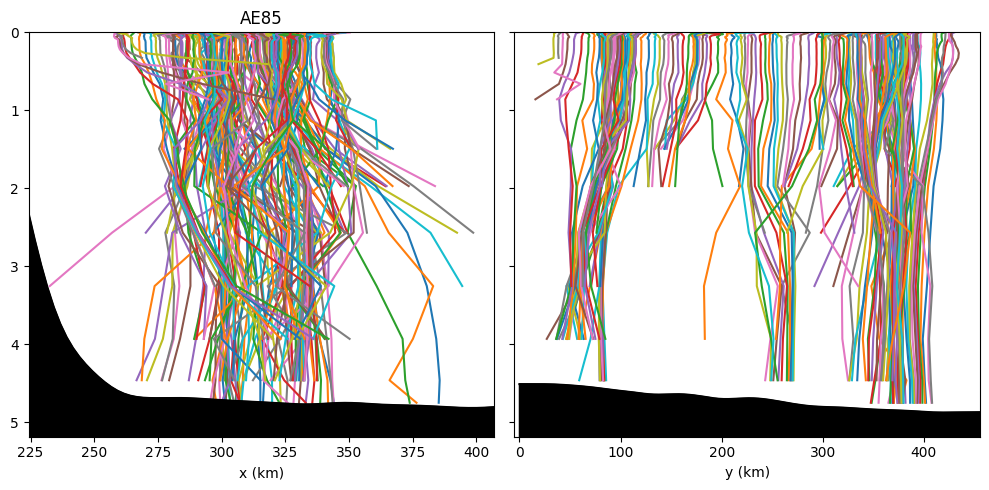

In [86]:
vert_plot(85)

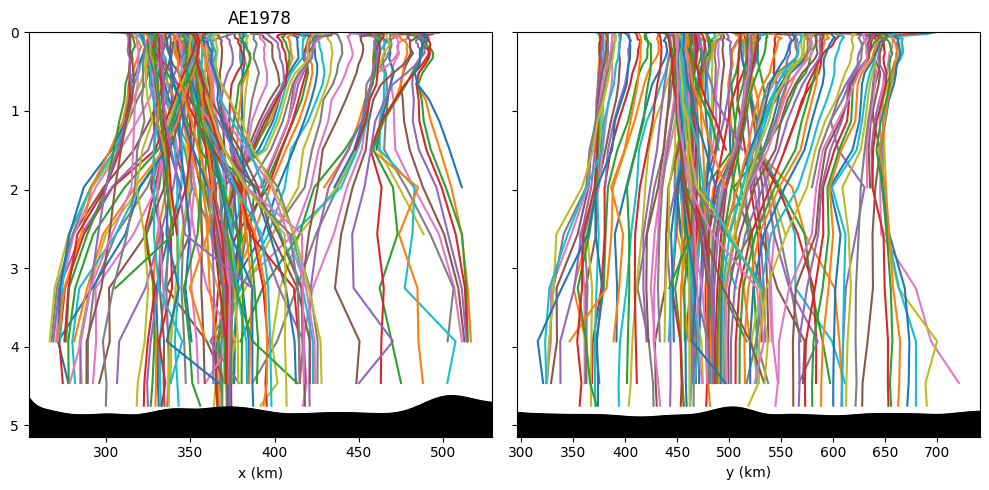

In [89]:
vert_plot(1978)


Text(0, 0.5, 'Latitude °N')

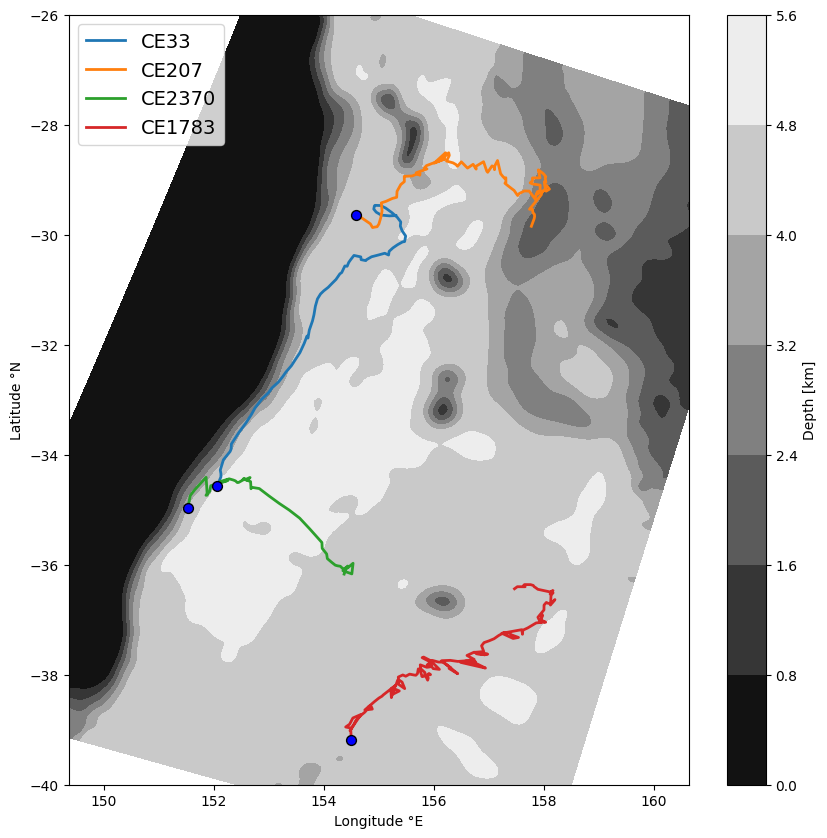

In [28]:
sample_eddies = [33, 207, 2370, 1783]

plt.figure(figsize=(10,10))
plt.contourf(lon_rho, lat_rho, h/1000, cmap='gray')
plt.colorbar(label='Depth [km]')

colors = plt.get_cmap('tab10').colors * 2

for e, eddy in enumerate(sample_eddies):
    if e >= 7:
        e += 2
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    cyc = df.iloc[0].Cyc
    plt.plot(df['Lon'], df['Lat'], label=f'{cyc}{eddy}',
            linewidth=2, color=colors[e%len(colors)])
    plt.scatter(df.iloc[-1]['Lon'], df.iloc[-1]['Lat'], edgecolors='k',
                color='r' if cyc=='AE' else 'b', zorder=10, s=50)

plt.legend(loc='upper left', fontsize=14)
plt.axis('equal')
plt.xlim(150, 160)
plt.ylim(-40, -26)
plt.xlabel('Longitude °E')
plt.ylabel('Latitude °N')

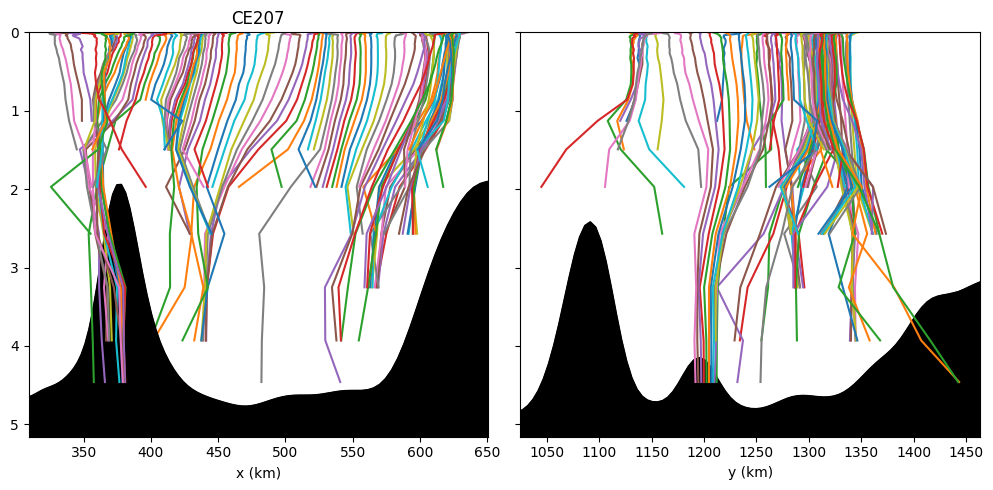

In [77]:
vert_plot(207)

In [81]:
def vert_plot(eddy):
    fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
    
    days = dic_eddies_vert[f'Eddy{eddy}']
    df_all = pd.concat(
        [df0 for df0 in days.values() if not df0.empty and not df0.isna().all().all()],
        ignore_index=True
    )
    
    df_mean = pd.DataFrame([{
        'Eddy': eddy,
        'x_mean': df_all['x'].mean(),
        'y_mean': df_all['y'].mean()
    }])
    
    dic = dic_eddies_vert[f'Eddy{eddy}']
    pmean = df_mean[df_mean.Eddy==eddy].iloc[0]
    for d, day in enumerate(dic.keys()):
        df = dic[day].copy()
        if len(df):
            axs[0].plot(df.x, -df.Depth/1000, zorder=0 if df.iloc[-1].y > pmean.y_mean else 2)
            axs[0].set_xlabel('x (km)')
        
            axs[1].plot(df.y, -df.Depth/1000, zorder=0 if df.iloc[-1].x > pmean.x_mean else 2)
            axs[1].set_xlabel('y (km)')
    xlim0 = axs[0].get_xlim()
    xlim1 = axs[1].get_xlim()
        
    jc = np.where(np.abs(pmean.y_mean-y_grid)==np.min(np.abs(pmean.y_mean-y_grid)))[0][0]
    axs[0].plot(x_grid, h[:, jc]/1000, 'k', zorder=1)
    ylim = axs[0].get_ylim()[1]
    ic = np.where(np.abs(pmean.x_mean-x_grid)==np.min(np.abs(pmean.x_mean-x_grid)))[0][0]
    axs[1].plot(y_grid, h[ic, :]/1000, 'k', zorder=1)
    ylim = max(ylim, axs[1].get_ylim()[1])
    
    jc = np.where(np.abs(pmean.y_mean - y_grid) == np.min(np.abs(pmean.y_mean - y_grid)))[0][0]
    axs[0].fill_between(x_grid, h[:, jc] / 1000, 10, color='k', zorder=1)
    
    ic = np.where(np.abs(pmean.x_mean - x_grid) == np.min(np.abs(pmean.x_mean - x_grid)))[0][0]
    axs[1].fill_between(y_grid, h[ic, :] / 1000, 10, color='k', zorder=1)
    
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    axs[0].set_title(f'{cyc}{eddy}')
    
    axs[0].set_xlim(xlim0)
    axs[1].set_xlim(xlim1)
    axs[0].set_ylim(0, ylim)
    axs[1].set_ylim(0, ylim)
    
    axs[0].invert_yaxis()
    
    plt.tight_layout()


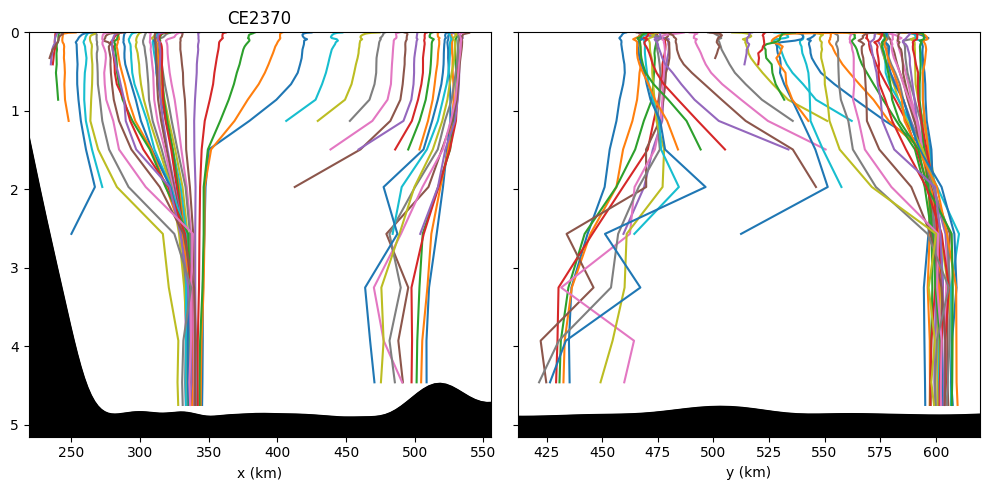

In [99]:
vert_plot(2370)